# Testing VAEAC
Let's test the existing code from the original implementation.

### Setup

In [1]:
inDrive = True

if inDrive:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/Hybrid-CLUE/MyImplementation

Mounted at /content/drive
/content/drive/MyDrive/Hybrid-CLUE/MyImplementation


In [2]:
# Updated notebook code using existing training infrastructure
# Add these at the VERY TOP of your notebook
import os
os.environ['OBJC_DISABLE_INITIALIZE_FORK_SAFETY'] = 'YES'  # Disable macOS fork safety
os.environ['PYTHONUNBUFFERED'] = '1'  # Better logging

import torch
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)  # Required for macOS

import torch
import torchvision
import matplotlib.pyplot as plt
from VAEAC.MNISTconv_bern import VAEAC_bern_net
import importlib
import VAEAC.train  # Import the train module
importlib.reload(VAEAC.train)  # Reload the module
from VAEAC.train import train_VAEAC  # Use existing training function
from src.masks import top_masker  # Use existing mask generator

# Add this to your notebook before importing train_VAEAC
import sys
from functools import partial
from tqdm.notebook import tqdm

# Store the original tqdm
import tqdm as tqdm_module
original_tqdm = tqdm_module.tqdm

# Replace with notebook version
tqdm_module.tqdm = tqdm

# Now import the training function
from VAEAC.train import train_VAEAC

# Configuration
config = {
    'input_dim': 784,
    'latent_dim': 20,
    'batch_size': 128,
    'epochs': 50,
    'lr': 3e-4,
    'cuda': torch.cuda.is_available(),
    'Nclass': 10,  # Enable joint (x,y) modeling
    'num_workers': min(4, os.cpu_count()//2),  # Use at most 4 workers
    'persistent_workers': True,  # Required for stability
    'multiprocessing_context': 'spawn'  # Explicit context
}

### 1. Load MNIST Data

In [3]:
class FlattenTransform(torch.nn.Module):
    def forward(self, x):
        return x.view(-1)

# Replace the lambda with this class
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    FlattenTransform()  # Now pickleable
])

# Rest of the code remains the same
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform  # Use modified transform,
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform  # Use modified transform,
)

# Create DataLoader with macOS-specific settings
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=config['num_workers'],
    persistent_workers=config['persistent_workers'],
    multiprocessing_context=config['multiprocessing_context'],
    pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    persistent_workers=config['persistent_workers'],
    multiprocessing_context=config['multiprocessing_context'],
    pin_memory=True
)

### 2. Initialize Model using existing class


In [4]:
model = mnistVAEAC_bern_net(
    input_dim=config['input_dim'] + config['Nclass'],
    latent_dim=config['latent_dim'],
    lr=config['lr'],
    targets=True,  # Critical for joint modeling
)


Net:
VAE_bern_net
Using device: cuda
    Total params: 2.71M


### 3. Use existing mask generator with label preservation

In [5]:
class JointMasker:
    def __init__(self, base_masker):
        self.base_masker = base_masker

    def __call__(self, x):
        mask = self.base_masker(x[:, :-10])
        full_mask = torch.cat([mask, torch.ones(x.size(0), 10).bool()], 1)
        return full_mask

    def __getstate__(self):
        # Needed for proper pickling
        return self.__dict__

    def __setstate__(self, d):
        # Needed for proper unpickling
        self.__dict__ = d

masker = JointMasker(top_masker(p=0.8))  # Use existing top_masker

### 4. Train using existing train_VAEAC function

In [6]:
model.load("./vaeac_mnist_models/theta_best.dat")

/content/drive/MyDrive/Hybrid-CLUE/MyImplementation/VAEAC/MNISTconv_bern.py:305: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, map_location

Model loaded successfully from ./vaeac_mnist_models/theta_best.dat



Network:

Train:
  init cost variables:


Epoch 1/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 1/50, vlb -241.5943, time: 38.75s
    vlb -131.160481 (-inf)



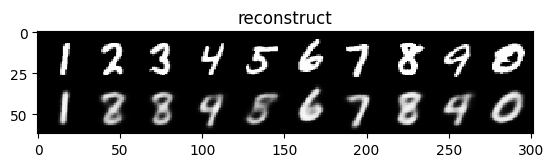

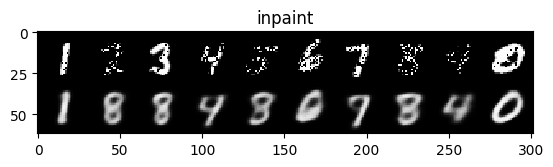

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 2/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 2/50, vlb -125.5381, time: 38.77s
    vlb -102.363550 (-131.160481)



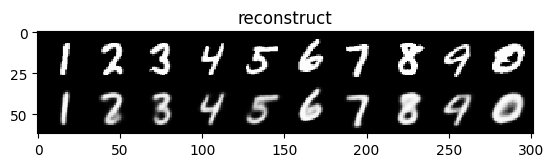

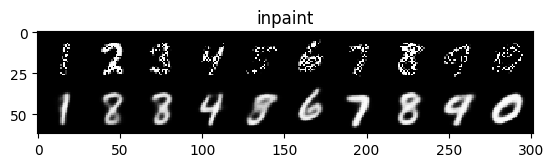

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 3/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 3/50, vlb -106.1571, time: 38.54s
    vlb -90.951913 (-102.363550)



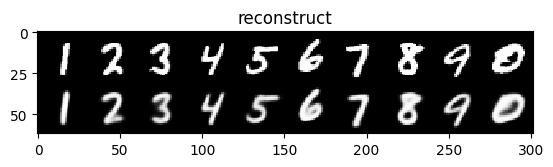

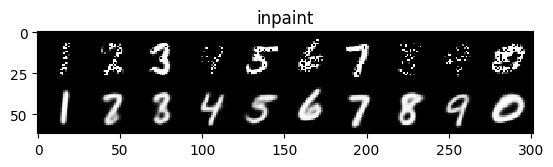

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 4/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 4/50, vlb -97.0963, time: 38.72s
    vlb -85.062314 (-90.951913)



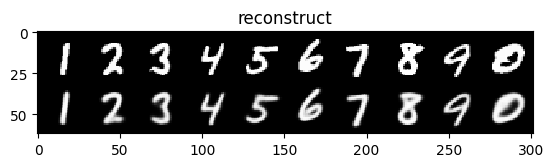

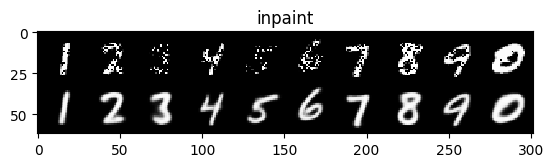

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 5/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 5/50, vlb -91.0872, time: 38.45s
    vlb -83.851342 (-85.062314)



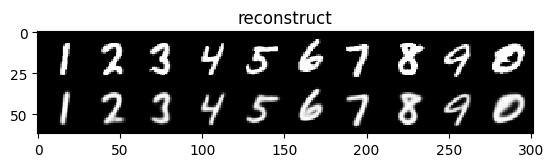

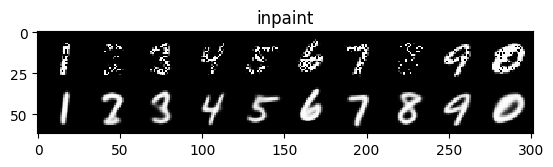

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 6/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 6/50, vlb -87.1128, time: 38.97s
    vlb -78.406949 (-83.851342)



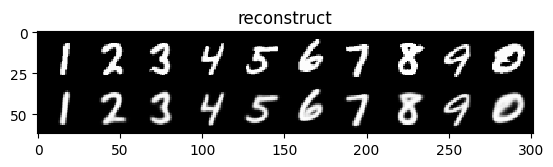

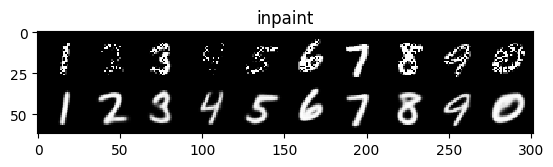

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 7/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 7/50, vlb -84.6602, time: 38.65s
    vlb -76.235513 (-78.406949)



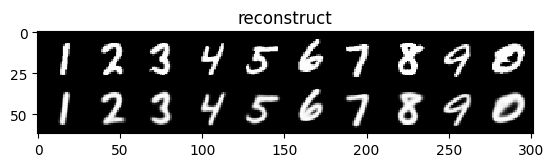

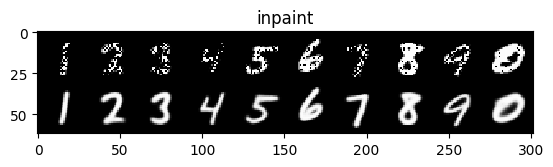

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 8/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 8/50, vlb -82.2869, time: 38.71s
    vlb -75.361382 (-76.235513)



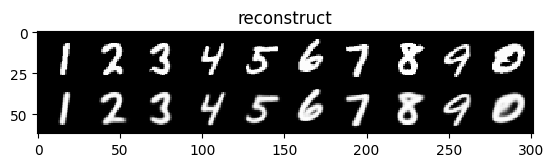

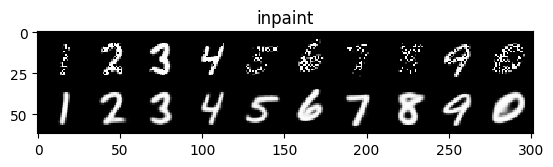

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 9/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 9/50, vlb -80.8790, time: 38.24s
    vlb -74.089670 (-75.361382)



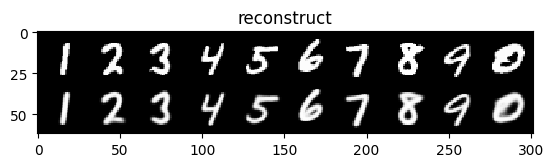

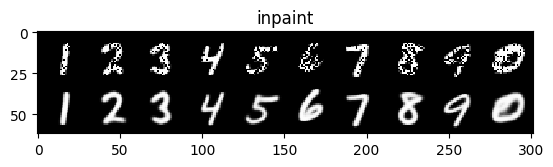

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 10/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 10/50, vlb -79.3408, time: 39.01s
    vlb -72.797488 (-74.089670)



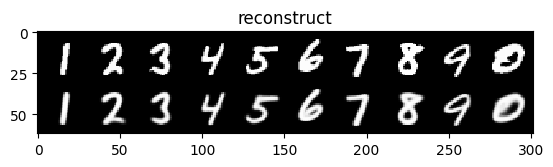

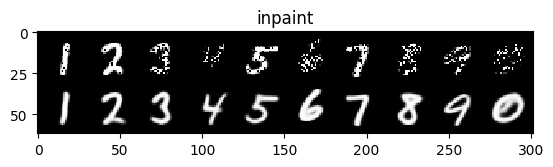

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 11/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/468 [11:58<?, ?it/s]


Epoch 11/50, vlb -78.2605, time: 39.30s
    vlb -72.325937 (-72.797488)



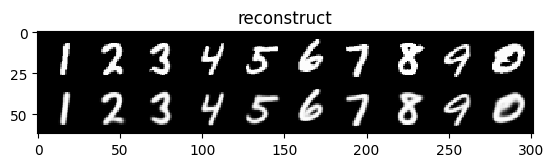

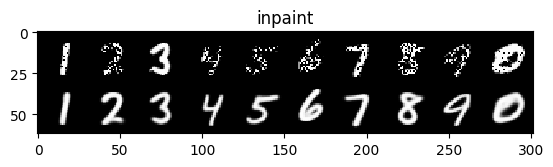

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 12/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 12/50, vlb -77.3716, time: 39.24s
    vlb -71.169475 (-72.325937)



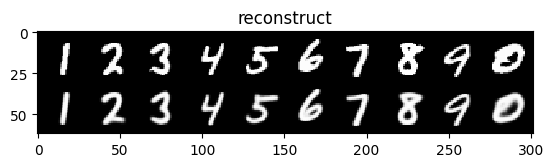

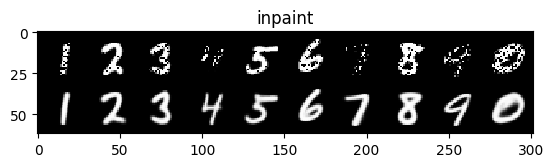

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 13/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 13/50, vlb -76.4756, time: 38.99s
    vlb -71.378262 (-71.169475)



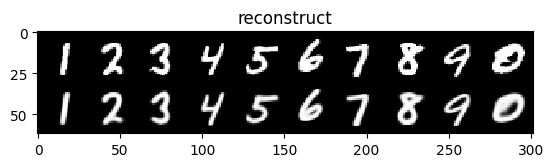

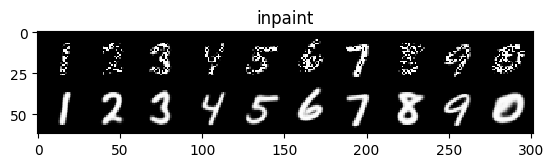

Epoch 14/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 14/50, vlb -75.9625, time: 39.27s
    vlb -70.944201 (-71.169475)



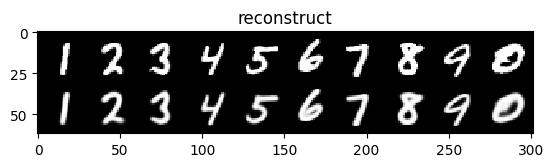

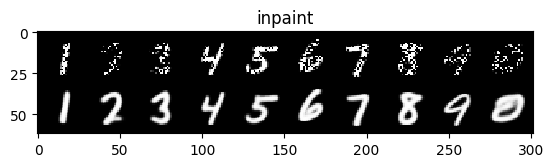

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 15/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 15/50, vlb -75.2626, time: 39.21s
    vlb -71.062402 (-70.944201)



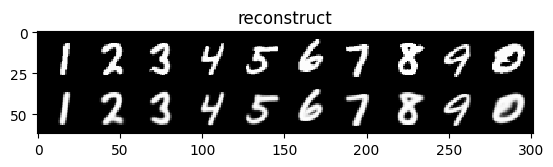

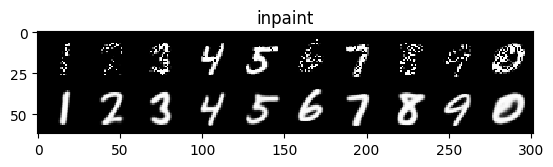

Epoch 16/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 16/50, vlb -74.5849, time: 39.04s
    vlb -69.633023 (-70.944201)



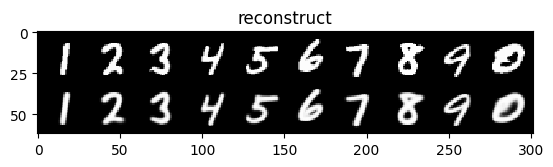

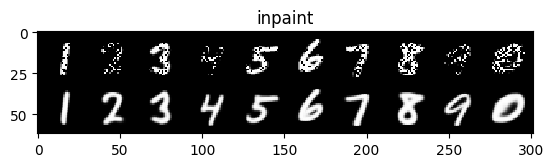

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 17/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 17/50, vlb -73.9531, time: 39.14s
    vlb -69.401104 (-69.633023)



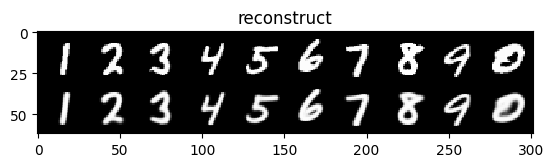

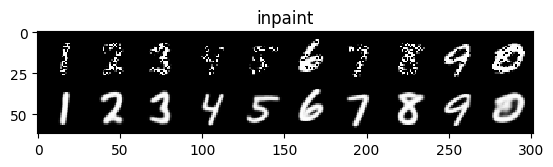

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 18/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 18/50, vlb -73.5348, time: 39.19s
    vlb -68.829759 (-69.401104)



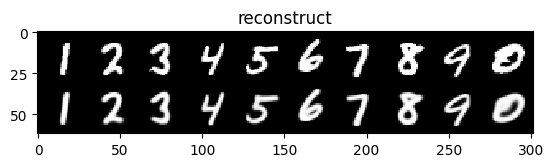

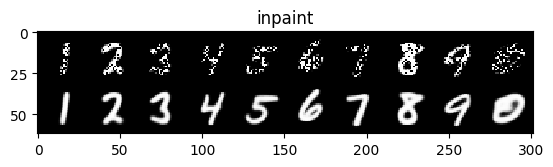

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 19/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 19/50, vlb -73.2724, time: 39.27s
    vlb -68.893117 (-68.829759)



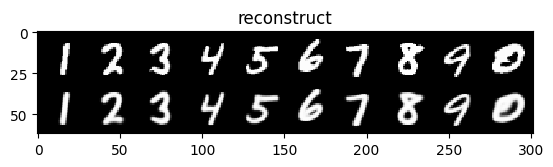

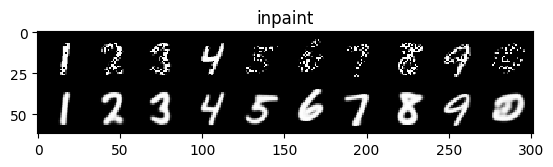

Epoch 20/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 20/50, vlb -72.7630, time: 39.34s
    vlb -68.591452 (-68.829759)



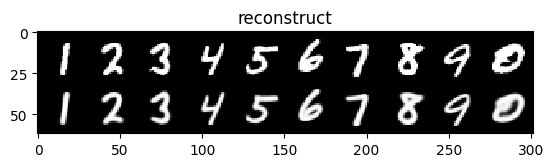

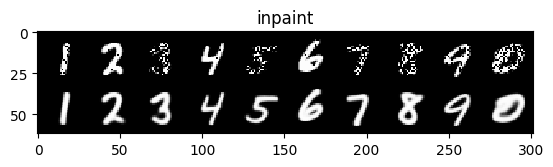

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 21/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 21/50, vlb -72.4220, time: 39.35s
    vlb -68.566877 (-68.591452)



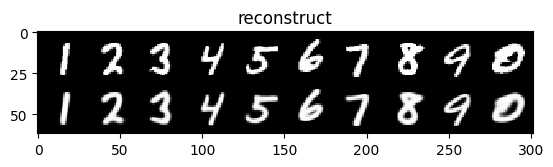

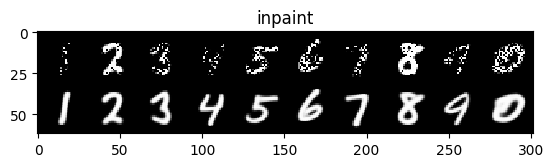

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 22/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 22/50, vlb -71.9950, time: 39.27s
    vlb -67.986494 (-68.566877)



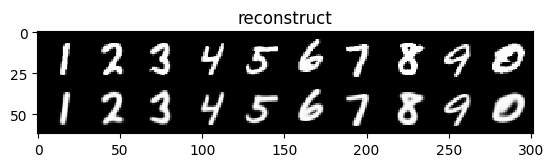

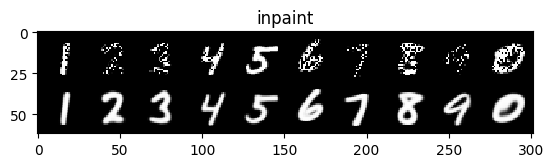

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 23/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 23/50, vlb -71.7818, time: 39.13s
    vlb -67.158423 (-67.986494)



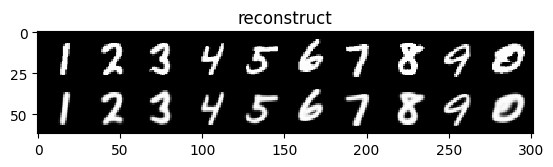

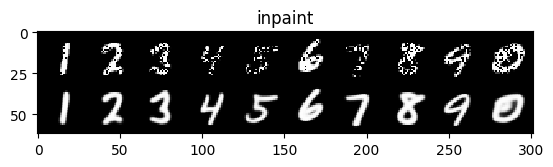

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 24/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 24/50, vlb -71.2795, time: 39.24s
    vlb -68.435083 (-67.158423)



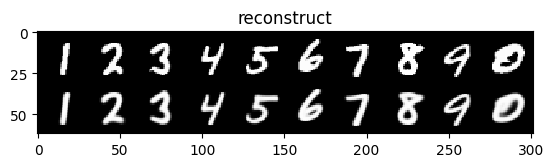

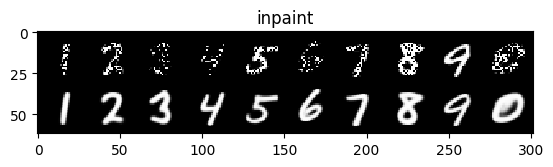

Epoch 25/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 25/50, vlb -71.1904, time: 39.34s
    vlb -66.895989 (-67.158423)



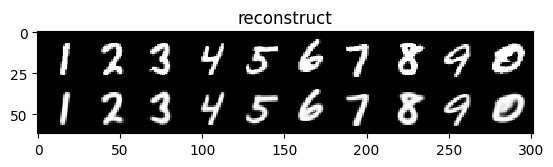

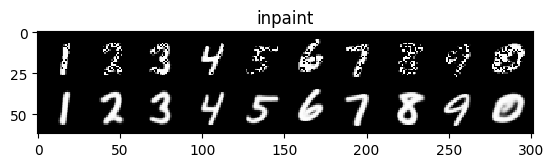

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 26/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 26/50, vlb -70.9094, time: 39.69s
    vlb -66.646621 (-66.895989)



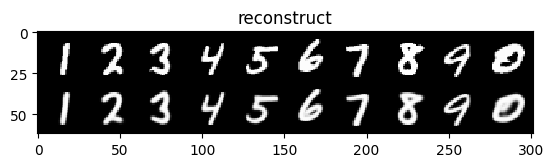

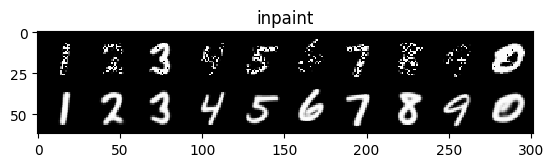

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 27/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 27/50, vlb -70.6359, time: 39.49s
    vlb -66.633825 (-66.646621)



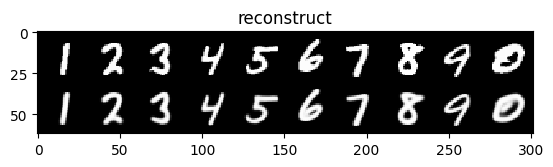

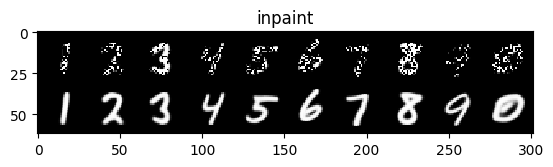

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 28/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 28/50, vlb -70.3406, time: 40.30s
    vlb -66.098653 (-66.633825)



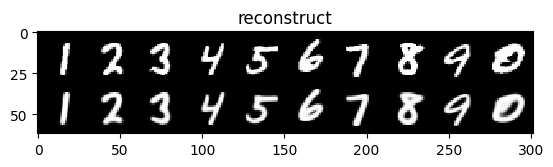

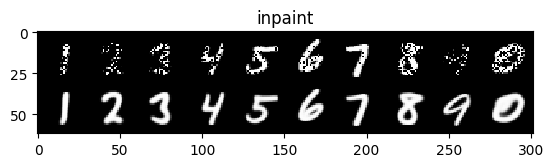

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 29/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 29/50, vlb -70.1314, time: 40.18s
    vlb -66.922973 (-66.098653)



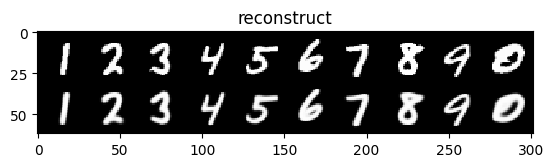

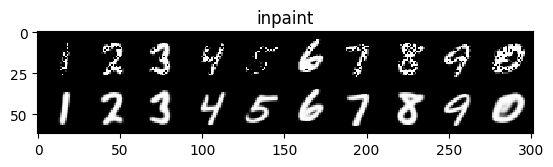

Epoch 30/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 30/50, vlb -69.8574, time: 39.42s
    vlb -66.416626 (-66.098653)



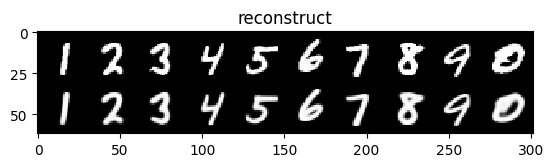

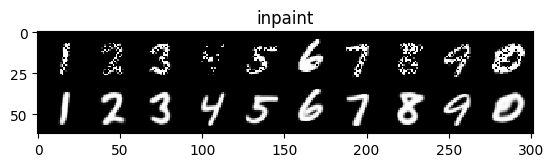

Epoch 31/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 31/50, vlb -69.6132, time: 39.83s
    vlb -65.830382 (-66.098653)



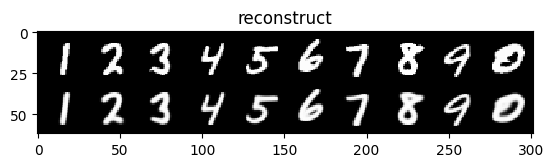

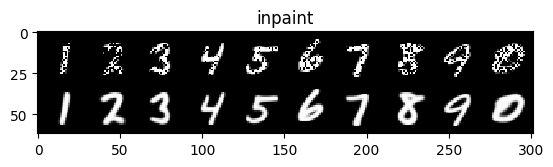

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 32/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 32/50, vlb -69.3832, time: 40.12s
    vlb -66.085073 (-65.830382)



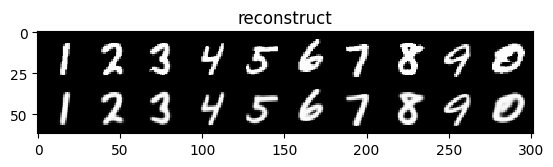

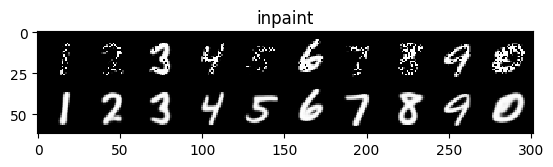

Epoch 33/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 33/50, vlb -69.3131, time: 40.07s
    vlb -66.044860 (-65.830382)



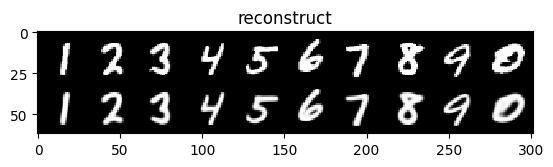

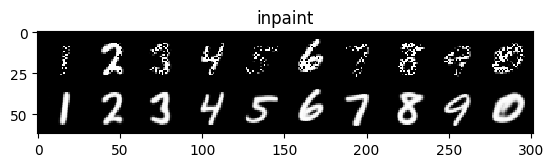

Epoch 34/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 34/50, vlb -68.9974, time: 39.72s
    vlb -65.318217 (-65.830382)



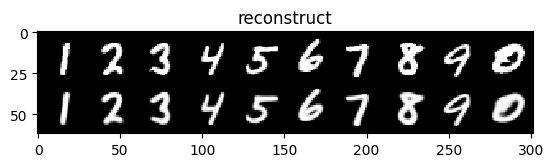

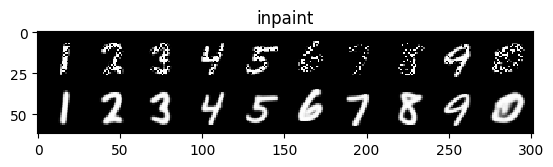

Model saved successfully to ./vaeac_mnist_models/theta_best.dat
Successfully saved model to ./vaeac_mnist_models/theta_best.dat


Epoch 35/50:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 35/50, vlb -68.8296, time: 39.73s
    vlb -65.560644 (-65.318217)



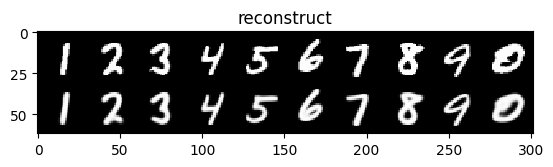

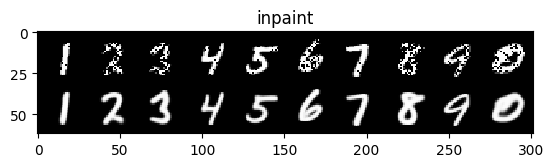

Epoch 36/50:   0%|          | 0/468 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
save_dir = './vaeac_mnist'
vlb_train, vlb_dev = train_VAEAC(
    net=model,
    masker=masker,
    name=save_dir,
    batch_size=config['batch_size'],
    nb_epochs=config['epochs'],
    trainset=train_dataset,
    valset=test_dataset,
    cuda=config['cuda'],
    flat_ims=True,
    train_plot=True,
    Nclass=config['Nclass'],
    early_stop=10
)

### 5. Visualization using existing model methods

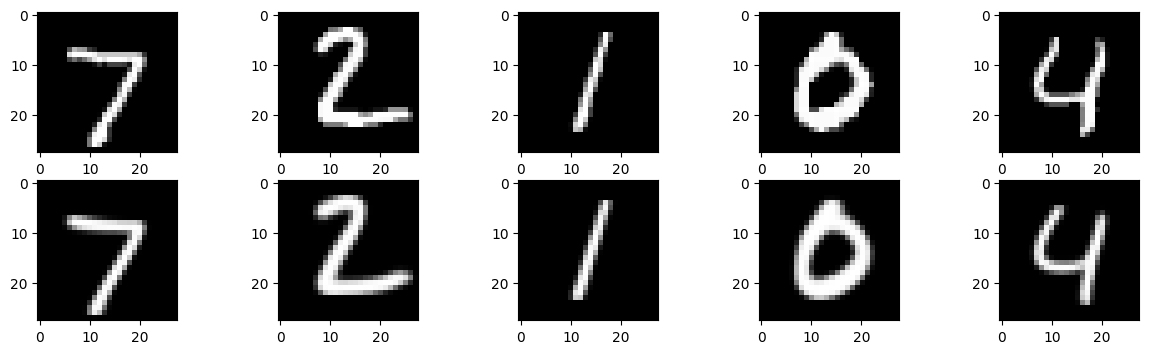

In [7]:
def plot_reconstructions(model, test_dataset):
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5)
    x, y = next(iter(test_loader))

    # Get the device of the model
    device = next(model.parameters()).device

    # Create combined input with dummy labels (on CPU initially)
    dummy_labels = torch.zeros(5, 10)
    combined_input = torch.cat([x, dummy_labels], 1)

    # Create sample mask using the combined input (masker works on CPU)
    mask = masker(combined_input)

    # Now move everything to the right device for model inference
    x = x.to(device)
    combined_input = combined_input.to(device)
    mask = mask.to(device)

    with torch.no_grad():
        # Pass the combined input to inpaint
        rec = model.inpaint(combined_input, mask, Nsample=1)[0]

    # Move everything back to CPU for visualization
    x_cpu = x.cpu()
    rec_cpu = rec.cpu()

    # Plotting code - only display the image part
    fig, axs = plt.subplots(2, 5, figsize=(15,4))
    for i in range(5):
        axs[0,i].imshow(x_cpu[i].view(28,28), cmap='gray')
        # Only take the image part (first 784 values) for visualization
        axs[1,i].imshow(rec_cpu[i, :784].view(28,28), cmap='gray')
    plt.show()

plot_reconstructions(model, test_dataset)

### 6. Train the undernet

In [37]:
import VAEAC.train
importlib.reload(VAEAC.train)
from VAEAC.train import train_under_VAEAC
import VAEAC.under_net  # Import the module, not just the class
importlib.reload(VAEAC.under_net)  # Reload the module
from VAEAC.under_net import under_VAEAC  # Now import the class


# Your existing code that uses under_VAEAC

under_vaeac = under_VAEAC(base_VAE=model, width=400, depth=2, latent_dim=20)
train_under_VAEAC(
    under_net=under_vaeac,
    base_vaeac=model,
    name="mnist",
    batch_size=128,
    nb_epochs=50,
    trainset=train_dataset,
    valset=test_dataset,
    flat_ims=True,  # Must match base VAEAC
    Nclass=10       # Must match base VAEAC
)


Net:
VAE_gauss_net
Using device: cuda
    Total params: 3.08M

Training under_VAEAC:

Train:
  init cost variables:


Epoch 1/50:   0%|          | 0/468 [00:00<?, ?it/s]

AttributeError: 'Tensor' object has no attribute 'log_prob'